In [1]:
import sys
import numpy as np
from astropy.io import fits
from astroscrappy import detect_cosmics
from matplotlib import pyplot as plt 
sys.path.append('aspired')

import twodspec
import standard

In [2]:
# Example data from SPRAT
# BDp33_2642_zpol
sprat_data = fits.open('examples/v_s_20190616_34_1_0_2.fits')[0].data


aspired/twodspec.py:103: RuntimeWarning: invalid value encountered in log10
  np.log10(img),


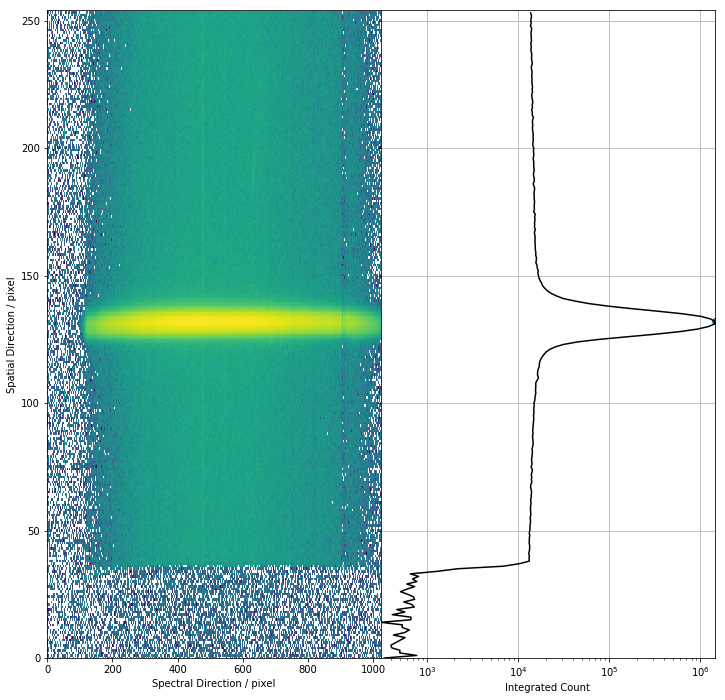

In [3]:
# (1) example of twodspec._find_peaks() with cosmic ray removal

# Set the spectral and spatial direction
Saxis = 1
Waxis = 0

# get the length in the spectral and spatial directions
spec_size = np.shape(sprat_data)[Waxis]
spatial_size = np.shape(sprat_data)[Saxis]

# the valid y-range of the chip (an array of int)
ydata = np.arange(spec_size)
ztot = np.sum(sprat_data, axis=Saxis)

peaks_y, heights_y = twodspec._find_peaks(detect_cosmics(sprat_data)[1], spec_size, spatial_size, ydata, ztot, f_height=0.2, display=True)

aspired/twodspec.py:331: RuntimeWarning: invalid value encountered in log10
  np.log10(img),


[ 23.68421053  71.05263158 118.42105263 165.78947368 213.15789474
 260.52631579 307.89473684 355.26315789 402.63157895 450.
 497.36842105 544.73684211 592.10526316 639.47368421 686.84210526
 734.21052632 781.57894737 828.94736842 876.31578947] [90.15079691 90.60139655 90.96721631 91.22159687 91.41044848 91.54328599
 91.6381537  91.70522797 91.74607636 91.76501059 91.77716074 91.77162353
 91.76119125 91.72662364 91.68940775 91.63722309 91.56849812 91.3665345
 91.0152493 ]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 

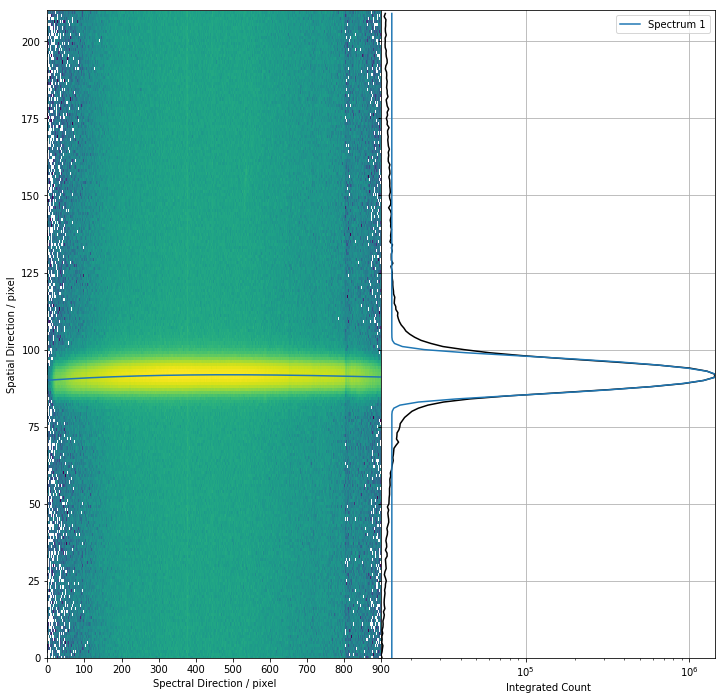

In [4]:
# (3) example of twodspec.ap_trace() with cosmic ray removal, selecting the 7 brightest spectra
#     in the pixel range covered by spatial_mask and spec_mask.
#     The 6th and 7th ones failed, error messages are printed but the code continues to run.

spec_mask = np.zeros(spec_size)
spec_mask[40:250] += 1
spec_mask = (spec_mask == 1)

spatial_mask = np.zeros(spatial_size)
spatial_mask[100:1000] += 1
spatial_mask = (spatial_mask == 1)

my, my_sigma = twodspec.ap_trace(sprat_data, nsteps=20, Saxis=1, spatial_mask=spatial_mask, spec_mask=spec_mask,
                                cosmic=True, n_spec=1, recenter=False, prevtrace=(0, ), 
                                fittype='spline', bigbox=8, silence=True, display=True)

aspired/twodspec.py:695: RuntimeWarning: invalid value encountered in log10
  min(median_trace+widthup+skysep+skywidth, len(img[0])), :]),


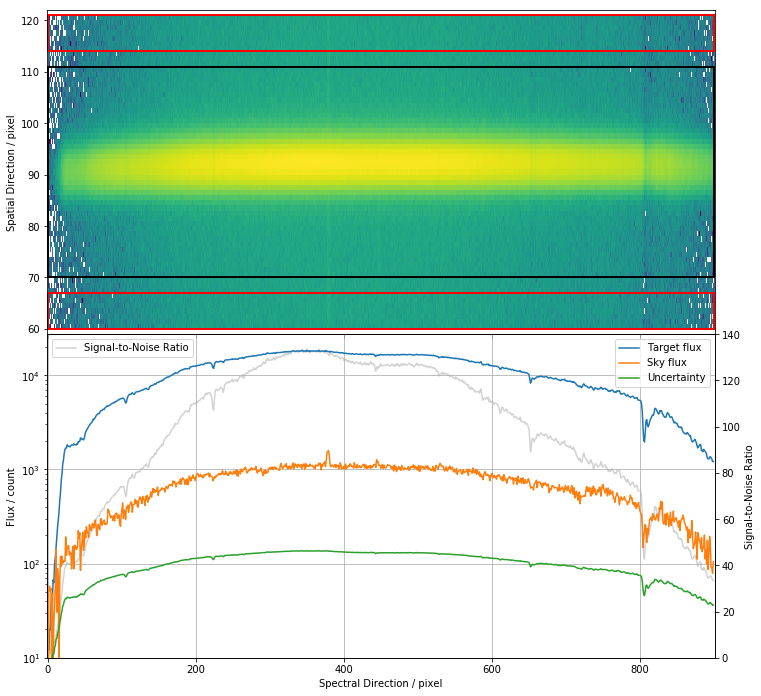

In [5]:
# (4b) (Optimal) Extracting spectrum by summing over the aperture along the trace
# my[0] is a special cases where skysep has to be increased to avoid crowding
spec, sky, err = twodspec.ap_extract(
    sprat_data,
    my[0],
    apwidth=20,
    trace_sigma = my_sigma[0],
    spatial_mask=spatial_mask,
    spec_mask=spec_mask,
    display=True)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(array([3200., 3201., 3202., ..., 9196., 9198., 9200.]),
 array([6.8253e-13, 6.8022e-13, 6.7979e-13, ..., 3.1712e-14, 3.1495e-14,
        3.1336e-14]))

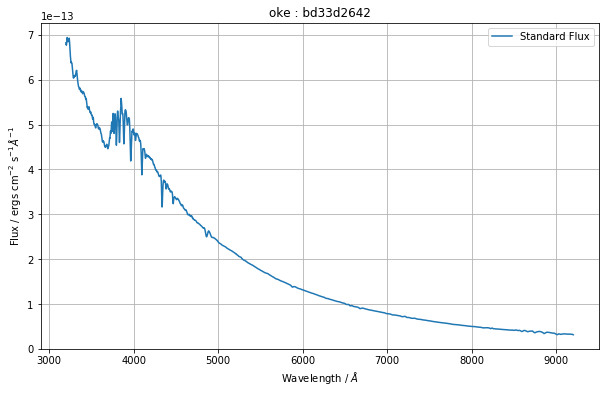

In [6]:
standard._read_standard('bd33d2642' ,'oke', cutoff=0.4, ftype='flux', display=True)

/usr/local/lib/python3.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


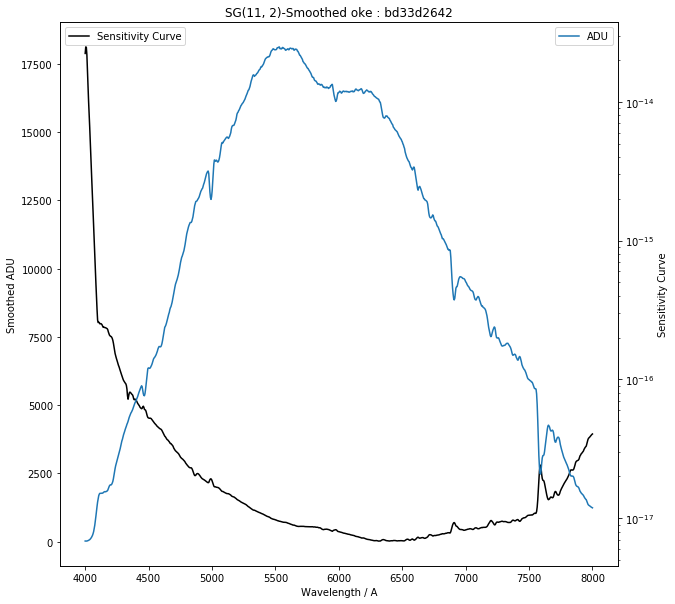

In [7]:
# Get the standard
standard_wave, standard_flux = standard._read_standard('bd33d2642' ,'oke', cutoff=0.4, ftype='flux', display=False)

# Get the sensitivity curves with and without smoothing
wave = np.arange(len(spec))*4.45+4000.
sencurve_smoothed = standard.get_sencurve(wave, spec, 'bd33d2642' ,'oke', cutoff=0.4, slength=11, sorder=2, display=True)


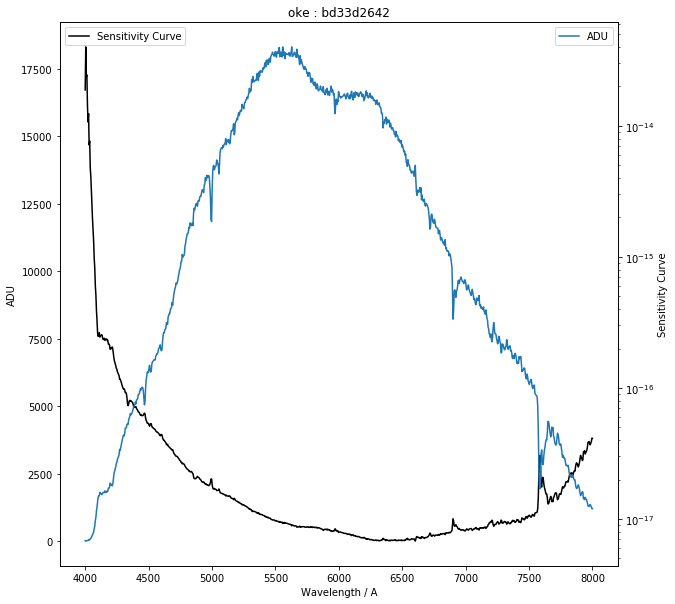

In [8]:
sencurve_not_smoothed = standard.get_sencurve(wave, spec, 'bd33d2642' ,'oke', smooth=False, display=True)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3461: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


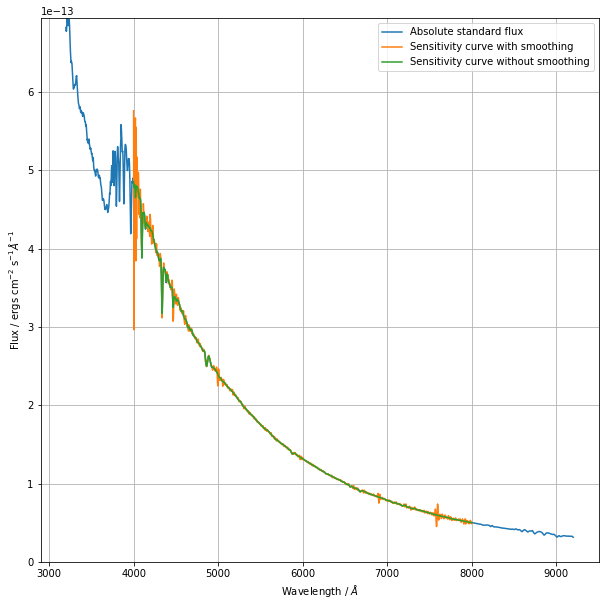

In [9]:
# Plot the three spectra
plt.figure(figsize=(10,10))
plt.plot(standard_wave, standard_flux, label='Absolute standard flux')
plt.plot(wave, spec * sencurve_smoothed(wave), label='Sensitivity curve with smoothing')
plt.plot(wave, spec * sencurve_not_smoothed(wave), label='Sensitivity curve without smoothing')
plt.xlabel(r'Wavelength / $\AA$')
plt.ylabel(r'Flux / ergs cm$^{-2}$ s$^{-1} \AA^{-1}$')
plt.ylim(ymin=0)
plt.ylim(ymax=max(standard_flux))
plt.grid()
plt.legend()